In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6075837839559239355
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10979282816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7984168762991305988
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


**Importing the necessary packages**

In [ ]:
# Tensorflow essentials
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import *

# specifically for cnn
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

import numpy as np 
import pandas as pd
import os
from sklearn.metrics import *
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
from glob import glob
from pathlib import Path
import random

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**Reading the image files**

In [ ]:

dire= 'F:\\Ml files\\Weed detection\\flower recognition\\data\\FINAL DATASET'
categories=['Alternanthera philoxeroide', 'Centella asiatica', 'Commelina benghalensis',
            'Cyperus ochraceus', 'Fimbristylis littoralis', 'Ipomoea aquatic',
            'Marsilea minuta', 'Panicum repens', 'Paspalum scrobiculatum',
            'Pteris vittata', 'Synedrella nodiflora']


In [ ]:
features=[]

for i in tqdm(categories):
    path=os.path.join(dire,i)
    num_classes=categories.index(i)
    for img in os.listdir(path):
        if img.endswith('.jpg'): 
            img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
            img_array=cv2.resize(img_array,(150,150))
            features.append([img_array,num_classes])

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [10:37<00:00, 57.93s/it]


In [ ]:
X=[]
y=[]
for i,j in features:
    X.append(i)
    y.append(j)

**Example of flower images per class**

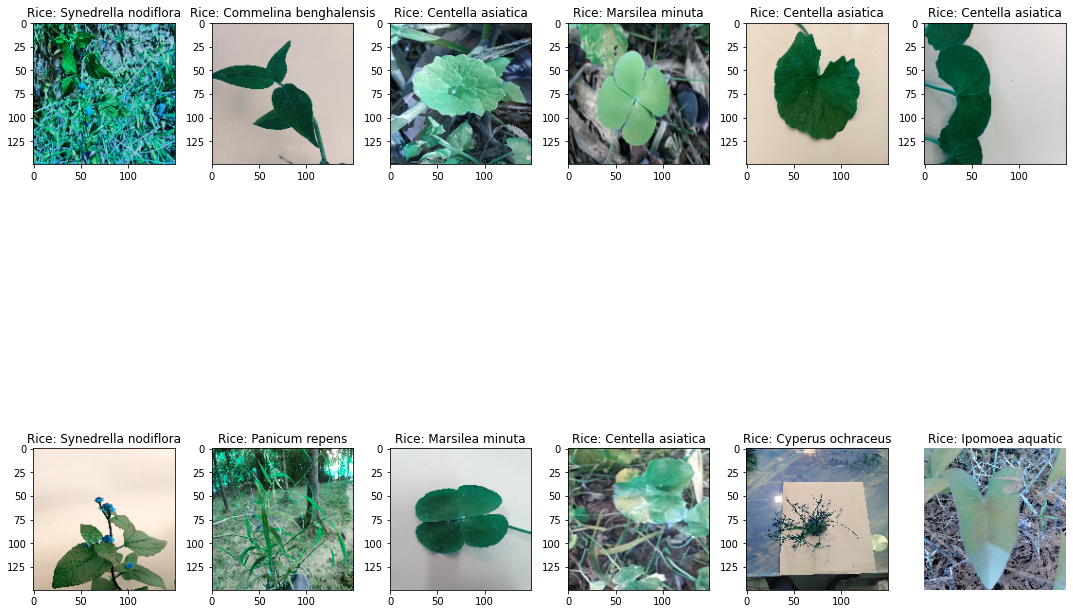

In [ ]:
fig,ax=plt.subplots(2,6)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range (6):
        l=np.random.randint(0,len(y))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Rice: '+categories[y[l]])
plt.axis('off')        
plt.tight_layout()

Reshaping and normalizing: the need of resizing the feature vetcor x is to meet the keras requirement and normalization is done to scale all the values in a similar range¶


In [ ]:
X=np.array(X).reshape(-1,150,150,3)/255.0

**Class destribution**

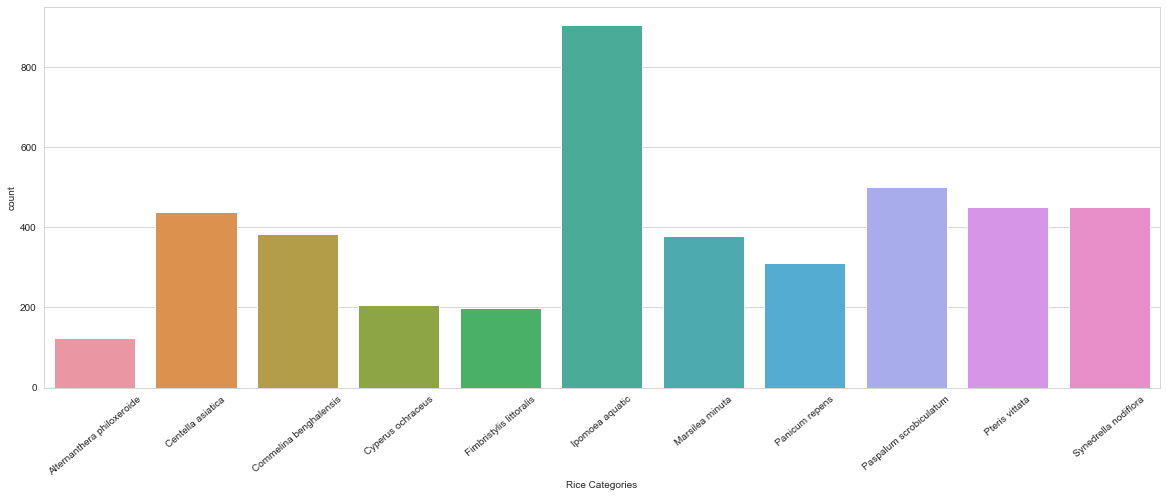

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,7))
fig=sns.countplot(y)
fig.set(xticks=range(len(categories)), xticklabels=[i for i in categories])
plt.xticks(rotation=40)
plt.xlabel('Rice Categories')
plt.show()

In [ ]:
list_Alternanthera=len([i for i in y if i==0])
list_Centella=len([i for i in y if i==1])
list_Commelina=len([i for i in y if i==2])
list_Cyperus=len([ i for i in y if i==3])
list_Fimbristylis=len([i for i in y if i==4])
list_Ipomoea = len([i for i in y if i==5])
list_Marsilea=len([i for i in y if i==6])
list_Panicum=len([i for i in y if i==7])
list_Paspalum=len([i for i in y if i==8])
list_Pteris=len([ i for i in y if i==9])
list_Synedrella=len([i for i in y if i==10])

list_species=[list_Alternanthera,list_Centella,list_Commelina,list_Cyperus,list_Fimbristylis,list_Ipomoea,
              list_Marsilea,list_Panicum, list_Paspalum,list_Pteris, list_Synedrella]

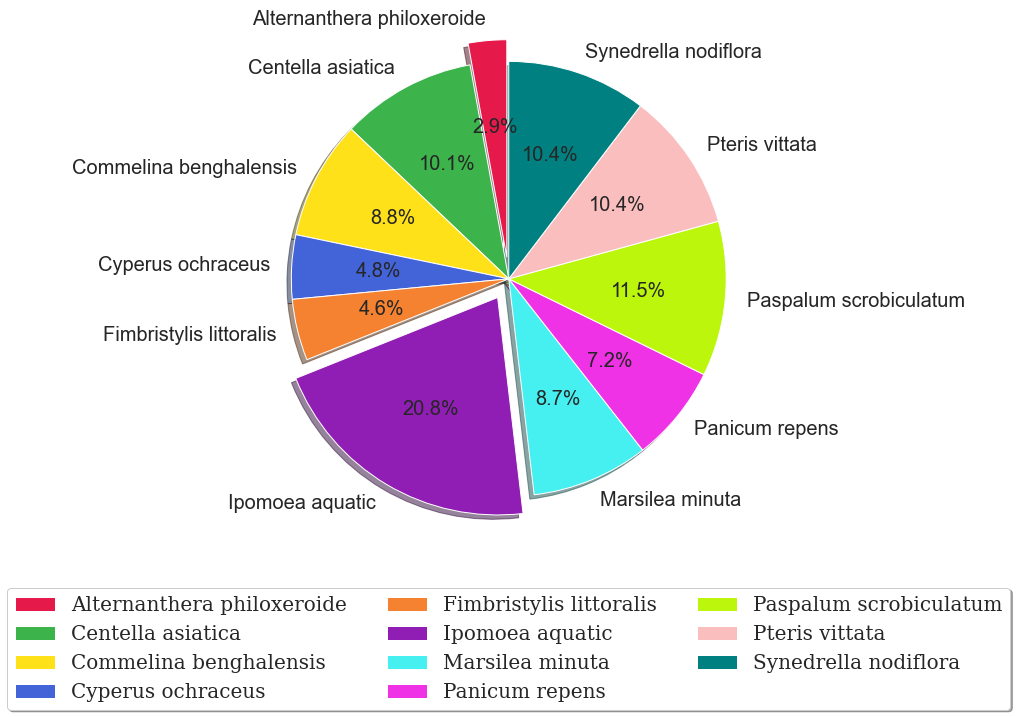

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.pie(list_species,labels=categories,startangle=90,colors=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080'],
        autopct='%1.1f%%',explode = (0.1,0,0,0,0,0.1,0,0,0,0,0),shadow=True,textprops={'fontsize': 20})

# plt.title('Percentage of images per class', fontsize = 40)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),prop={'size': 20},
          fancybox=True, shadow=True, ncol=3)
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

**Train Test split**

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=12)

In [ ]:
print("Shape of x_train", x_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of x_test", x_test.shape)
print("Shape of y_test", y_test.shape)

Shape of x_train (3476, 150, 150, 3)
Shape of y_train (3476, 11)
Shape of x_test (870, 150, 150, 3)
Shape of y_test (870, 11)


**CNN Model**

In [ ]:
def cnn_model(input_shape):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(input_shape)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2, padding="same"))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2, padding="same"))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(128, (3, 3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(2, 2, padding="same"))
  model.add(Dropout(0.2))
  
  model.add(Flatten())
  
  model.add(Dense(512, activation="relu"))
  
  model.add(Dropout(0.2))
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(11, activation="softmax"))

  model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  
  return model

**Augmentation to avoid overfitting**

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

**Callbacks**

In [ ]:
keras.backend.clear_session()
#callback function for early stopping

accuracy_threshold = 0.99999

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>99.99):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()

In [ ]:
checkpoint_path = 'F:\\Ml files\\Weed detection\\flower recognition\\model\\kfold-cnn-class_11.h5'
epochs=50

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False),
    acc_callback
]

In [ ]:
#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=128):
    model = None
    input_shape = 150,150,3
    model = cnn_model(input_shape)
    results = model.fit_generator(datagen.flow(t_x, t_y, batch_size=BATCH_SIZE),
                              epochs = EPOCHS, validation_data = (val_x,val_y),
                              callbacks= callbacks,
                              verbose = 1, steps_per_epoch= t_x.shape[0] // 128)
    
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [ ]:
n_folds=5
epochs = 100
batch_size = 128

model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/100
24/24 [==============================] - 15s 587ms/step - loss: 2.6023 - accuracy: 0.1783 - val_loss: 2.3200 - val_accuracy: 0.2213

Epoch 00001: val_loss did not improve from 2.00321
Epoch 2/100
24/24 [==============================] - 14s 563ms/step - loss: 2.2851 - accuracy: 0.2053 - val_loss: 2.2813 - val_accuracy: 0.2213

Epoch 00002: val_loss did not improve from 2.00321
Epoch 3/100
24/24 [==============================] - 13s 555ms/step - loss: 2.2107 - accuracy: 0.2430 - val_loss: 2.1715 - val_accuracy: 0.2902

Epoch 00003: val_loss did not improve from 2.00321
Epoch 4/100
24/24 [==============================] - 14s 578ms/step - loss: 2.0952 - accuracy: 0.2807 - val_loss: 2.0913 - val_accuracy: 0.3218

Epoch 00004: val_loss did not improve from 2.00321
Epoch 5/100
24/24 [==============================] - 14s 598ms/step - loss: 1.9873 - accuracy: 0.3287 - val_loss: 1.9427 - val_accuracy: 0.3506

Epoch 00005: val_loss improved from 2.00321 to 1.9

24/24 [==============================] - 14s 572ms/step - loss: 0.9746 - accuracy: 0.6553 - val_loss: 0.8414 - val_accuracy: 0.7184

Epoch 00018: val_loss did not improve from 0.36511
Epoch 19/100
24/24 [==============================] - 14s 560ms/step - loss: 0.9326 - accuracy: 0.6790 - val_loss: 0.8785 - val_accuracy: 0.7155

Epoch 00019: val_loss did not improve from 0.36511
Epoch 20/100
24/24 [==============================] - 14s 567ms/step - loss: 0.9213 - accuracy: 0.6790 - val_loss: 0.9805 - val_accuracy: 0.6954

Epoch 00020: val_loss did not improve from 0.36511
Epoch 21/100
24/24 [==============================] - 13s 553ms/step - loss: 0.8615 - accuracy: 0.6987 - val_loss: 1.0272 - val_accuracy: 0.6609

Epoch 00021: val_loss did not improve from 0.36511
Epoch 22/100
24/24 [==============================] - 14s 578ms/step - loss: 0.8324 - accuracy: 0.7147 - val_loss: 0.8768 - val_accuracy: 0.7126

Epoch 00022: val_loss did not improve from 0.36511
Epoch 23/100
24/24 [========


Epoch 00004: val_loss did not improve from 0.36511
Epoch 5/100
24/24 [==============================] - 14s 593ms/step - loss: 1.9999 - accuracy: 0.3087 - val_loss: 1.8807 - val_accuracy: 0.3563

Epoch 00005: val_loss did not improve from 0.36511
Epoch 6/100
24/24 [==============================] - 14s 581ms/step - loss: 1.8876 - accuracy: 0.3443 - val_loss: 1.7747 - val_accuracy: 0.3851

Epoch 00006: val_loss did not improve from 0.36511
Epoch 7/100
24/24 [==============================] - 14s 587ms/step - loss: 1.7161 - accuracy: 0.3997 - val_loss: 1.6082 - val_accuracy: 0.4253

Epoch 00007: val_loss did not improve from 0.36511
Epoch 8/100
24/24 [==============================] - 14s 586ms/step - loss: 1.6009 - accuracy: 0.4430 - val_loss: 1.4398 - val_accuracy: 0.4598

Epoch 00008: val_loss did not improve from 0.36511
Epoch 9/100
24/24 [==============================] - 15s 606ms/step - loss: 1.4478 - accuracy: 0.4937 - val_loss: 1.3933 - val_accuracy: 0.5230

Epoch 00009: val_lo


Epoch 00045: val_loss did not improve from 0.36511
Epoch 46/100
24/24 [==============================] - 14s 584ms/step - loss: 0.3797 - accuracy: 0.8637 - val_loss: 0.5551 - val_accuracy: 0.8017

Epoch 00046: val_loss did not improve from 0.36511
Epoch 47/100
24/24 [==============================] - 13s 552ms/step - loss: 0.3781 - accuracy: 0.8670 - val_loss: 0.5678 - val_accuracy: 0.7960

Epoch 00047: val_loss did not improve from 0.36511
Epoch 48/100
24/24 [==============================] - 14s 558ms/step - loss: 0.3919 - accuracy: 0.8637 - val_loss: 0.5677 - val_accuracy: 0.7989

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00048: val_loss did not improve from 0.36511
Epoch 49/100
24/24 [==============================] - 14s 574ms/step - loss: 0.3966 - accuracy: 0.8600 - val_loss: 0.5652 - val_accuracy: 0.8017

Epoch 00049: val_loss did not improve from 0.36511
Epoch 50/100
24/24 [==============================] - 13s 553ms/step - loss: 0

24/24 [==============================] - 14s 587ms/step - loss: 0.7533 - accuracy: 0.7483 - val_loss: 0.7948 - val_accuracy: 0.7155

Epoch 00028: val_loss did not improve from 0.36511
Epoch 29/100
24/24 [==============================] - 14s 578ms/step - loss: 0.6860 - accuracy: 0.7620 - val_loss: 0.6950 - val_accuracy: 0.7529

Epoch 00029: val_loss did not improve from 0.36511
Epoch 30/100
24/24 [==============================] - 14s 588ms/step - loss: 0.6324 - accuracy: 0.7827 - val_loss: 0.7465 - val_accuracy: 0.7356

Epoch 00030: val_loss did not improve from 0.36511
Epoch 31/100
24/24 [==============================] - 14s 581ms/step - loss: 0.5825 - accuracy: 0.7917 - val_loss: 0.7535 - val_accuracy: 0.7615

Epoch 00031: val_loss did not improve from 0.36511
Epoch 32/100
24/24 [==============================] - 14s 581ms/step - loss: 0.6435 - accuracy: 0.7783 - val_loss: 0.6004 - val_accuracy: 0.7845

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513

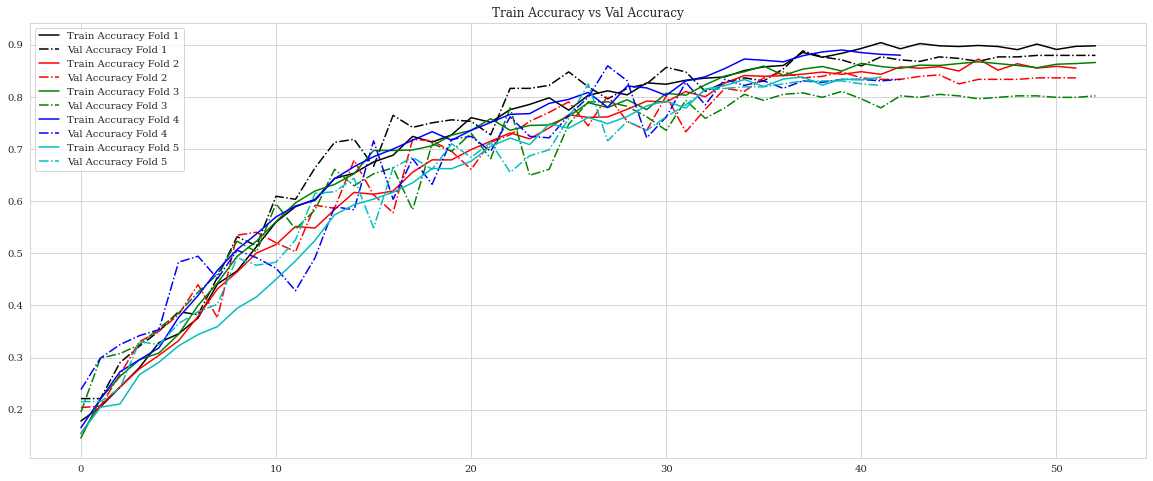

In [ ]:
plt.figure(figsize=(20, 8))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='c', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='c', linestyle = "dashdot")
plt.legend()
plt.show()

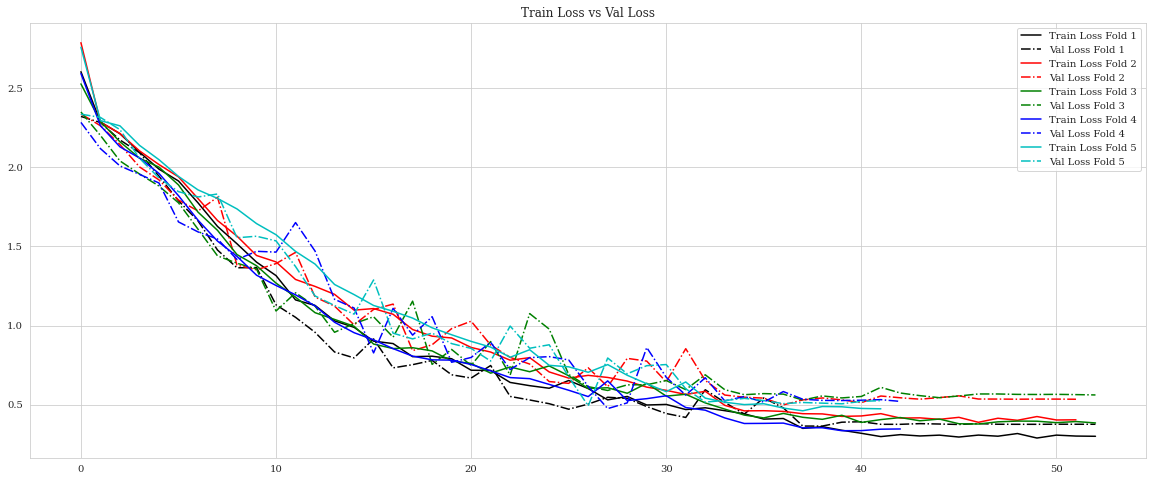

In [ ]:
plt.figure(figsize=(20, 8))
plt.title('Train Loss vs Val Loss')
plt.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['loss'], label='Train Loss Fold 4', color='blue', )
plt.plot(model_history[3].history['val_loss'], label='Val Loss Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['loss'], label='Train Loss Fold 5', color='c', )
plt.plot(model_history[4].history['val_loss'], label='Val Loss Fold 5', color='c', linestyle = "dashdot")
plt.legend()
plt.show()

In [ ]:
#Load the model that was saved by ModelCheckpoint
nFoldCnnModel = load_model('F:\\Ml files\\Weed detection\\flower recognition\\model\\kfold-cnn-class_11.h5')
preds=nFoldCnnModel.predict(x_test)
predictions=np.argmax(preds,axis=1)

In [ ]:
from sklearn.metrics import classification_report
Y_test =np.argmax(y_test,axis=1)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.94      0.72      0.81        82
           2       0.78      0.94      0.85        79
           3       0.76      0.81      0.79        32
           4       0.89      0.97      0.93        35
           5       0.98      0.97      0.97       175
           6       0.77      0.87      0.81        83
           7       0.86      0.90      0.88        69
           8       0.76      0.83      0.79        93
           9       0.92      0.76      0.83        91
          10       0.91      0.92      0.92       103

    accuracy                           0.87       870
   macro avg       0.86      0.85      0.85       870
weighted avg       0.88      0.87      0.87       870



In [ ]:
def report_generate(Y_test, predictions):
  report = pd.DataFrame(classification_report(y_true = Y_test, y_pred = predictions, output_dict=True)).transpose()
  report = report.rename(index={'0': 'Alternanthera philoxeroide','1':'Centella asiatica','2':'Commelina benghalensis',
                                '3':'Cyperus ochraceus', '4':'Fimbristylis littoralis', '5':'Ipomoea aquatic',
                               '6': 'Marsilea minuta','7':'Panicum repens','8':'Paspalum scrobiculatum',
                                '9':'Pteris vittata', '10':'Synedrella nodiflora'})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)
  columns = ['precision','recall','f1-score']
  report.columns = columns
  plt = report.plot(kind='bar',figsize=(12,6))
  
  plot=plt.tick_params(rotation=40)
  
  return plot,report

(None,
                             precision  recall  f1-score
 Alternanthera philoxeroide      90.91   71.43     80.00
 Centella asiatica               93.65   71.95     81.38
 Commelina benghalensis          77.89   93.67     85.06
 Cyperus ochraceus               76.47   81.25     78.79
 Fimbristylis littoralis         89.47   97.14     93.15
 Ipomoea aquatic                 98.26   96.57     97.41
 Marsilea minuta                 76.60   86.75     81.36
 Panicum repens                  86.11   89.86     87.94
 Paspalum scrobiculatum          76.24   82.80     79.38
 Pteris vittata                  92.00   75.82     83.13
 Synedrella nodiflora            91.35   92.23     91.79
 accuracy                        87.01   87.01     87.01
 macro avg                       86.27   85.41     85.40
 weighted avg                    87.73   87.01     86.99)

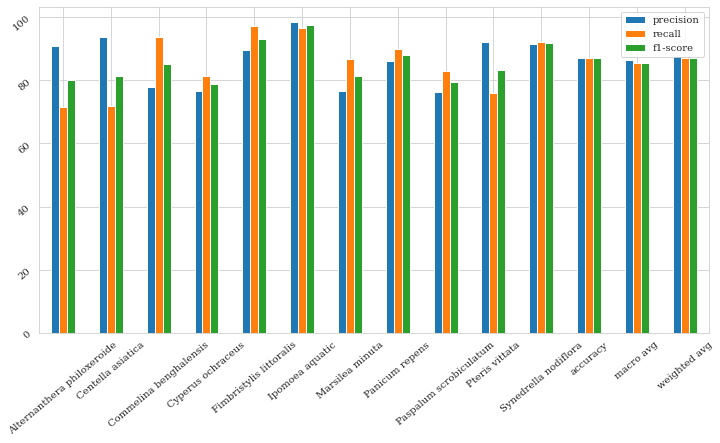

In [ ]:
report_generate(Y_test, predictions)

In [ ]:
#confusion matrix
def conf_matrix(Y_test, y_pred):

  cm = confusion_matrix(Y_test, y_pred) 
# Transform to df for easier plotting
  
  cm_df = pd.DataFrame(cm,
                       index = ['Alternanthera philoxeroide', 'Centella asiatica', 'Commelina benghalensis',
            'Cyperus ochraceus', 'Fimbristylis littoralis', 'Ipomoea aquatic',
            'Marsilea minuta', 'Panicum repens', 'Paspalum scrobiculatum',
            'Pteris vittata', 'Synedrella nodiflora'], 
                       columns = ['Alternanthera philoxeroide', 'Centella asiatica', 'Commelina benghalensis',
            'Cyperus ochraceus', 'Fimbristylis littoralis', 'Ipomoea aquatic',
            'Marsilea minuta', 'Panicum repens', 'Paspalum scrobiculatum',
            'Pteris vittata', 'Synedrella nodiflora'])
  plt.figure(figsize=(10,7))
  sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.xticks(rotation = 45)
  plt.yticks(rotation = 45)
  plt.show()
  plt.close()

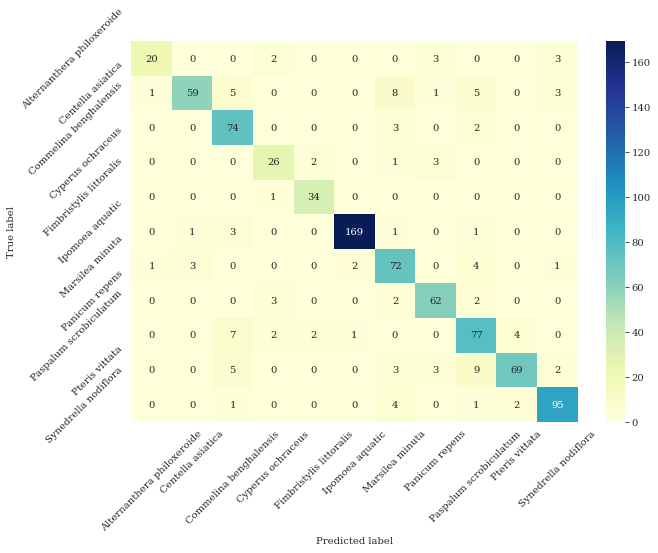

In [ ]:
conf_matrix(Y_test,predictions)

ROC AUC score: 0.9205128439133659


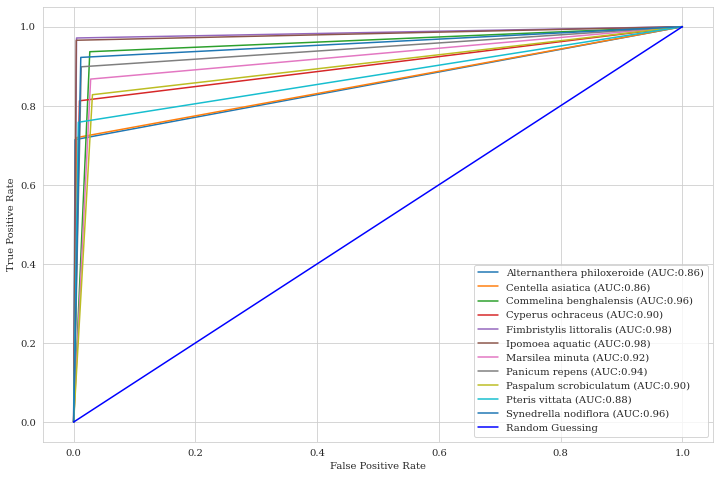

In [ ]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
print('ROC AUC score:', multiclass_roc_auc_score(Y_test,predictions))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


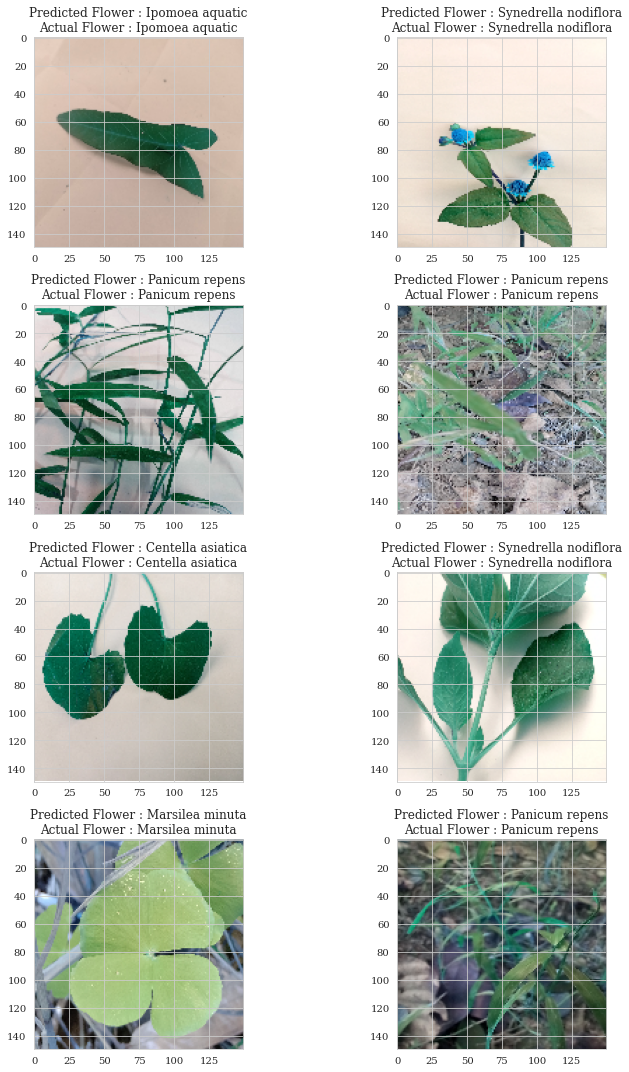

In [ ]:
correct_class=[]
incorrect_class=[]
i=0
for i in range(len(y_test)):
    if(np.argmax(y_test[i])==predictions[i]):
        correct_class.append(i)
    if(len(correct_class)==8):
        break

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[correct_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ categories[predictions[correct_class[count]]] +"\n"+"Actual Flower : "+ categories[np.argmax(y_test[correct_class[count]])])
        plt.tight_layout()
        count+=1

In [ ]:
i=0
for i in range(len(y_test)):
    
    if (np.argmax(y_test[i])!=predictions[i]):
        
        incorrect_class.append(i)
    if (len(incorrect_class)==8):
        break


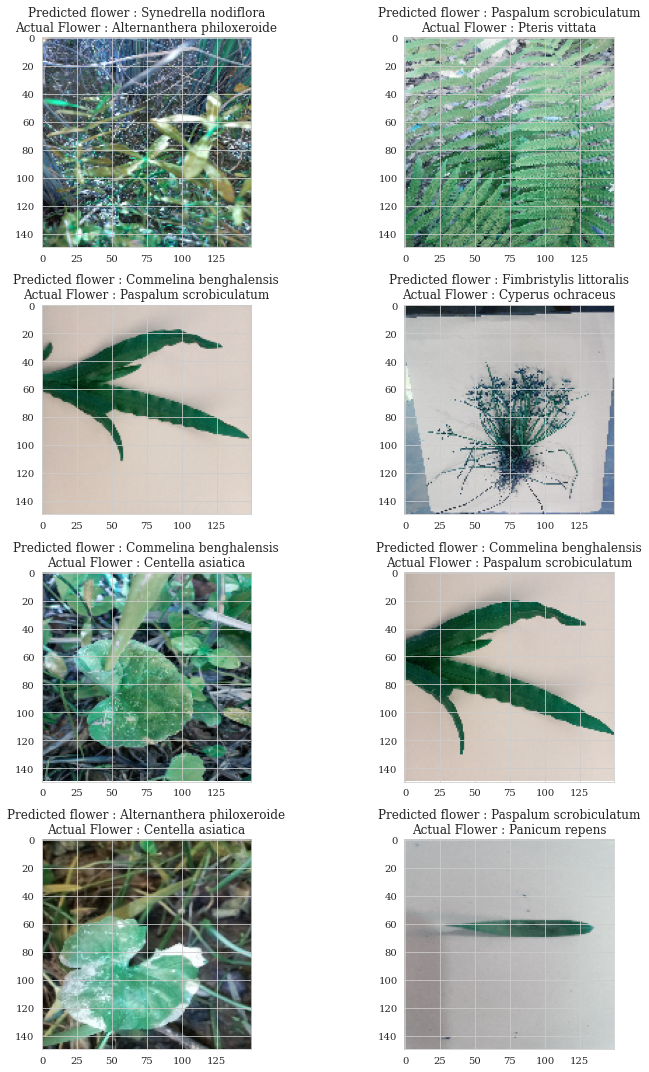

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range(4):
    for j in range(2):
        ax[i,j].imshow(x_test[incorrect_class[count]])
        ax[i,j].set_title("Predicted flower : " + categories[predictions[incorrect_class[count]]] + "\n"+"Actual Flower : " +categories[np.argmax(y_test[incorrect_class[count]])])
        plt.tight_layout()
        count+=1

# VGG16

In [ ]:
def vgg_model(input_shape):
    Base_model = VGG16(include_top= False, weights='imagenet',input_shape = (input_shape), pooling='avg')
    VGG16_model = Sequential()
    VGG16_model.add(Base_model)
    VGG16_model.add(Dense(256,activation='relu'))
    # adding prediction(softmax) layer
    VGG16_model.add(Dense(11,activation="softmax"))
    VGG16_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    VGG16_model.summary()
    return VGG16_model

In [ ]:
#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=128):
    model = None
    input_shape = 150,150,3
    model = vgg_model(input_shape)
    results = model.fit_generator(datagen.flow(t_x, t_y, batch_size=BATCH_SIZE),
                              epochs = EPOCHS, validation_data = (val_x,val_y),
                              callbacks= callbacks,
                              verbose = 1, steps_per_epoch= t_x.shape[0] // 128)
    
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [ ]:
checkpoint_path = 'F:\\Ml files\\Weed detection\\flower recognition\\model\\K-fold-11_VGG16.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False),
    acc_callback
]

In [ ]:
n_folds=5
epochs = 100
batch_size = 128

VGG_model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    VGG_model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 11)                2827      
Total params: 14,848,843
Trainable params: 14,848,843
Non-trainable params: 0
_________________________________________________________________


C:\Users\Ovi\anaconda3\envs\tensrgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
24/24 [==============================] - 193s 6s/step - loss: 5.8801 - accuracy: 0.1529 - val_loss: 2.3283 - val_accuracy: 0.1667

Epoch 00001: val_loss improved from inf to 2.32831, saving model to F:\Ml files\Weed detection\flower recognition\model\K-fold-11_VGG16.h5
Epoch 2/100
24/24 [==============================] - 141s 6s/step - loss: 2.3757 - accuracy: 0.2017 - val_loss: 2.4506 - val_accuracy: 0.1753

Epoch 00002: val_loss did not improve from 2.32831
Epoch 3/100
24/24 [==============================] - 114s 5s/step - loss: 2.2926 - accuracy: 0.2227 - val_loss: 2.1123 - val_accuracy: 0.2730

Epoch 00003: val_loss improved from 2.32831 to 2.11230, saving model to F:\Ml files\Weed detection\flower recognition\model\K-fold-11_VGG16.h5
Epoch 4/100
24/24 [==============================] - 114s 5s/step - loss: 2.0917 - accuracy: 0.2812 - val_loss: 2.0211 - val_accuracy: 0.2931

Epoch 00004: val_loss improved from 2.11230 to 2.02114, saving model to F:\Ml files\Weed detect


Epoch 00032: val_loss improved from 0.48176 to 0.42429, saving model to F:\Ml files\Weed detection\flower recognition\model\K-fold-11_VGG16.h5
Epoch 33/100
24/24 [==============================] - 115s 5s/step - loss: 0.3855 - accuracy: 0.8611 - val_loss: 0.3903 - val_accuracy: 0.8649

Epoch 00033: val_loss improved from 0.42429 to 0.39026, saving model to F:\Ml files\Weed detection\flower recognition\model\K-fold-11_VGG16.h5
Epoch 34/100
24/24 [==============================] - 114s 5s/step - loss: 0.4089 - accuracy: 0.8628 - val_loss: 0.4131 - val_accuracy: 0.8534

Epoch 00034: val_loss did not improve from 0.39026
Epoch 35/100
24/24 [==============================] - 117s 5s/step - loss: 0.3068 - accuracy: 0.8917 - val_loss: 0.3428 - val_accuracy: 0.8793

Epoch 00035: val_loss improved from 0.39026 to 0.34280, saving model to F:\Ml files\Weed detection\flower recognition\model\K-fold-11_VGG16.h5
Epoch 36/100
24/24 [==============================] - 114s 5s/step - loss: 0.3431 - acc

24/24 [==============================] - 114s 5s/step - loss: 0.4813 - accuracy: 0.8359 - val_loss: 0.3965 - val_accuracy: 0.8506

Epoch 00043: val_loss did not improve from 0.24767
Epoch 44/100
24/24 [==============================] - 114s 5s/step - loss: 0.4061 - accuracy: 0.8484 - val_loss: 0.4694 - val_accuracy: 0.8420

Epoch 00044: val_loss did not improve from 0.24767
Epoch 45/100
24/24 [==============================] - 114s 5s/step - loss: 0.4607 - accuracy: 0.8317 - val_loss: 0.3681 - val_accuracy: 0.8736

Epoch 00045: val_loss did not improve from 0.24767
Epoch 46/100
24/24 [==============================] - 114s 5s/step - loss: 0.3775 - accuracy: 0.8657 - val_loss: 0.4251 - val_accuracy: 0.8362

Epoch 00046: val_loss did not improve from 0.24767
Epoch 47/100
24/24 [==============================] - 114s 5s/step - loss: 0.3489 - accuracy: 0.8783 - val_loss: 0.3599 - val_accuracy: 0.8592

Epoch 00047: val_loss did not improve from 0.24767
Epoch 48/100
24/24 [==================


Epoch 00046: val_loss did not improve from 0.24767
Epoch 47/100
24/24 [==============================] - 115s 5s/step - loss: 0.3338 - accuracy: 0.8802 - val_loss: 0.4289 - val_accuracy: 0.8793

Epoch 00047: val_loss did not improve from 0.24767
Epoch 48/100
24/24 [==============================] - 115s 5s/step - loss: 0.3281 - accuracy: 0.8825 - val_loss: 0.4315 - val_accuracy: 0.8736

Epoch 00048: val_loss did not improve from 0.24767
Epoch 49/100
24/24 [==============================] - 115s 5s/step - loss: 0.3351 - accuracy: 0.8810 - val_loss: 0.4636 - val_accuracy: 0.8621

Epoch 00049: val_loss did not improve from 0.24767
Epoch 50/100
24/24 [==============================] - 115s 5s/step - loss: 0.2927 - accuracy: 0.8942 - val_loss: 0.4712 - val_accuracy: 0.8621

Epoch 00050: val_loss did not improve from 0.24767
Epoch 51/100
24/24 [==============================] - 115s 5s/step - loss: 0.2884 - accuracy: 0.8951 - val_loss: 0.4722 - val_accuracy: 0.8592

Epoch 00051: val_loss di


Epoch 00043: val_loss did not improve from 0.24767
Epoch 44/100
24/24 [==============================] - 115s 5s/step - loss: 0.3823 - accuracy: 0.8702 - val_loss: 0.4086 - val_accuracy: 0.8678

Epoch 00044: val_loss did not improve from 0.24767
Epoch 45/100
24/24 [==============================] - 117s 5s/step - loss: 0.3516 - accuracy: 0.8828 - val_loss: 0.4079 - val_accuracy: 0.8764

Epoch 00045: val_loss did not improve from 0.24767
Epoch 46/100
24/24 [==============================] - 115s 5s/step - loss: 0.3488 - accuracy: 0.8681 - val_loss: 0.4024 - val_accuracy: 0.8764

Epoch 00046: val_loss did not improve from 0.24767
Epoch 47/100
24/24 [==============================] - 115s 5s/step - loss: 0.3087 - accuracy: 0.8872 - val_loss: 0.4039 - val_accuracy: 0.8937

Epoch 00047: val_loss did not improve from 0.24767
Epoch 48/100
24/24 [==============================] - 115s 5s/step - loss: 0.3410 - accuracy: 0.8859 - val_loss: 0.4034 - val_accuracy: 0.8908

Epoch 00048: val_loss di

Epoch 1/100
24/24 [==============================] - 116s 5s/step - loss: 2.7342 - accuracy: 0.1638 - val_loss: 2.2537 - val_accuracy: 0.2845

Epoch 00001: val_loss did not improve from 0.24767
Epoch 2/100
24/24 [==============================] - 115s 5s/step - loss: 2.2526 - accuracy: 0.2408 - val_loss: 2.1488 - val_accuracy: 0.2960

Epoch 00002: val_loss did not improve from 0.24767
Epoch 3/100
24/24 [==============================] - 115s 5s/step - loss: 2.0885 - accuracy: 0.2757 - val_loss: 2.0216 - val_accuracy: 0.3333

Epoch 00003: val_loss did not improve from 0.24767
Epoch 4/100
24/24 [==============================] - 115s 5s/step - loss: 1.9677 - accuracy: 0.3103 - val_loss: 1.9217 - val_accuracy: 0.3333

Epoch 00004: val_loss did not improve from 0.24767
Epoch 5/100
24/24 [==============================] - 115s 5s/step - loss: 1.8774 - accuracy: 0.3130 - val_loss: 1.9061 - val_accuracy: 0.3477

Epoch 00005: val_loss did not improve from 0.24767
Epoch 6/100
24/24 [===========

24/24 [==============================] - 115s 5s/step - loss: 0.2455 - accuracy: 0.9176 - val_loss: 0.3972 - val_accuracy: 0.8678

Epoch 00043: val_loss did not improve from 0.24767
Epoch 44/100
24/24 [==============================] - 115s 5s/step - loss: 0.3052 - accuracy: 0.8929 - val_loss: 0.3676 - val_accuracy: 0.8736

Epoch 00044: val_loss did not improve from 0.24767
Epoch 45/100
24/24 [==============================] - 115s 5s/step - loss: 0.2361 - accuracy: 0.9148 - val_loss: 0.2533 - val_accuracy: 0.8994

Epoch 00045: val_loss did not improve from 0.24767
Epoch 46/100
24/24 [==============================] - 115s 5s/step - loss: 0.1777 - accuracy: 0.9424 - val_loss: 0.3093 - val_accuracy: 0.9080

Epoch 00046: val_loss did not improve from 0.24767
Epoch 47/100
24/24 [==============================] - 115s 5s/step - loss: 0.1834 - accuracy: 0.9403 - val_loss: 0.6105 - val_accuracy: 0.8448

Epoch 00047: val_loss did not improve from 0.24767
Epoch 48/100
24/24 [==================

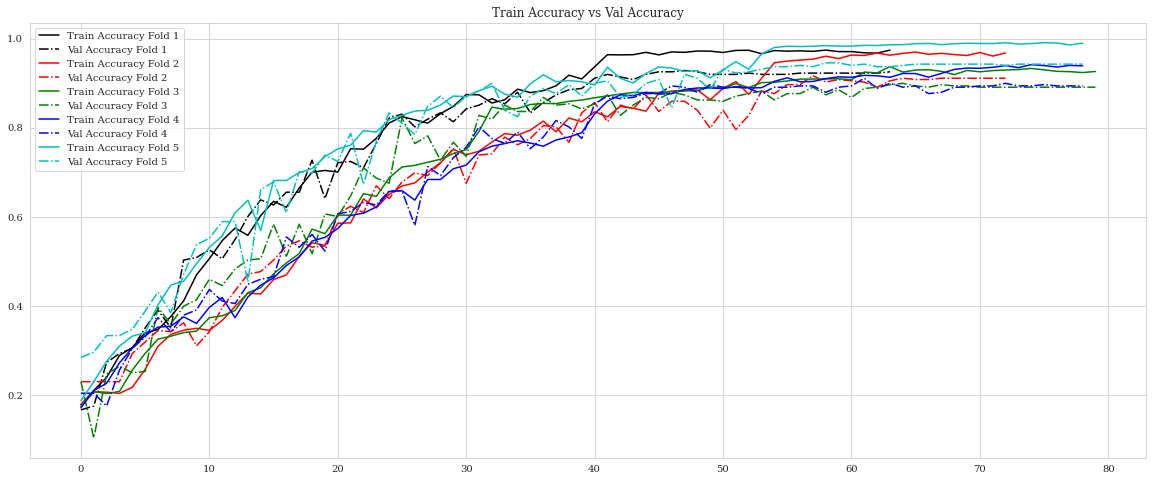

In [ ]:
plt.figure(figsize=(20, 8))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(VGG_model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(VGG_model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(VGG_model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(VGG_model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(VGG_model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(VGG_model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(VGG_model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(VGG_model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(VGG_model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='c', )
plt.plot(VGG_model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='c', linestyle = "dashdot")
plt.legend()
plt.show()

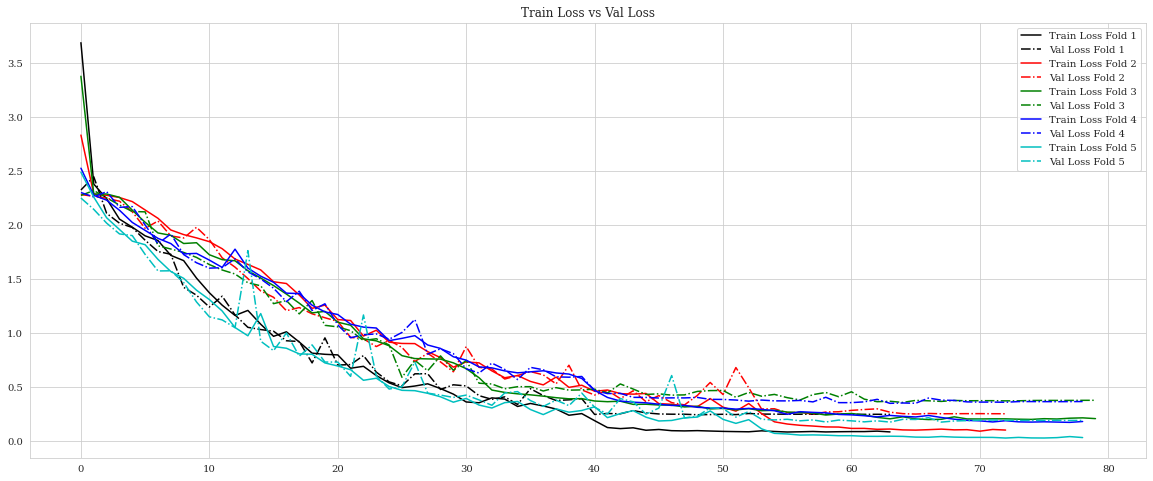

In [ ]:
plt.figure(figsize=(20, 8))
plt.title('Train Loss vs Val Loss')
plt.plot(VGG_model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(VGG_model_history[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(VGG_model_history[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(VGG_model_history[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
plt.plot(VGG_model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(VGG_model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.plot(VGG_model_history[3].history['loss'], label='Train Loss Fold 4', color='blue', )
plt.plot(VGG_model_history[3].history['val_loss'], label='Val Loss Fold 4', color='blue', linestyle = "dashdot")
plt.plot(VGG_model_history[4].history['loss'], label='Train Loss Fold 5', color='c', )
plt.plot(VGG_model_history[4].history['val_loss'], label='Val Loss Fold 5', color='c', linestyle = "dashdot")
plt.legend()
plt.show()

In [ ]:
#Load the model that was saved by ModelCheckpoint
nFoldVGG16Model = load_model('F:\\Ml files\\Weed detection\\flower recognition\\model\\K-fold-11_VGG16.h5')
preds=nFoldVGG16Model.predict(x_test)
predictions=np.argmax(preds,axis=1)

In [ ]:
from sklearn.metrics import classification_report
Y_test =np.argmax(y_test,axis=1)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.79      0.86        28
           1       0.93      0.98      0.95        82
           2       0.95      0.99      0.97        79
           3       0.84      1.00      0.91        32
           4       0.83      0.86      0.85        35
           5       1.00      0.99      0.99       175
           6       0.99      0.94      0.96        83
           7       0.91      0.93      0.92        69
           8       0.96      0.98      0.97        93
           9       0.99      0.99      0.99        91
          10       0.98      0.92      0.95       103

    accuracy                           0.96       870
   macro avg       0.94      0.94      0.94       870
weighted avg       0.96      0.96      0.96       870



(None,
                             precision  recall  f1-score
 Alternanthera philoxeroide      95.65   78.57     86.27
 Centella asiatica               93.02   97.56     95.24
 Commelina benghalensis          95.12   98.73     96.89
 Cyperus ochraceus               84.21  100.00     91.43
 Fimbristylis littoralis         83.33   85.71     84.51
 Ipomoea aquatic                100.00   98.86     99.43
 Marsilea minuta                 98.73   93.98     96.30
 Panicum repens                  91.43   92.75     92.09
 Paspalum scrobiculatum          95.79   97.85     96.81
 Pteris vittata                  98.90   98.90     98.90
 Synedrella nodiflora            97.94   92.23     95.00
 accuracy                        95.75   95.75     95.75
 macro avg                       94.01   94.10     93.90
 weighted avg                    95.90   95.75     95.74)

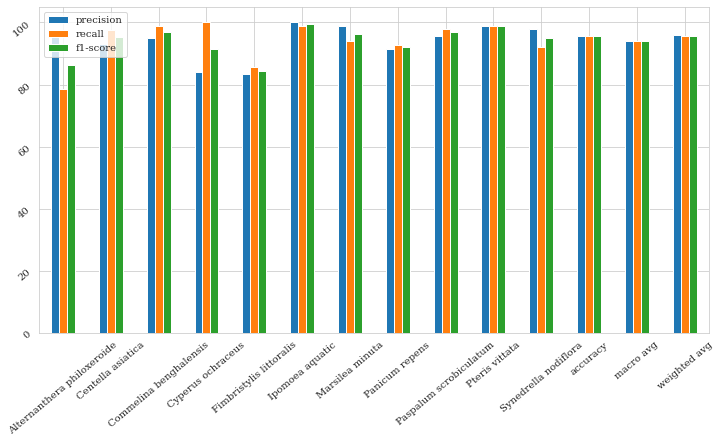

In [ ]:
report_generate(Y_test, predictions)

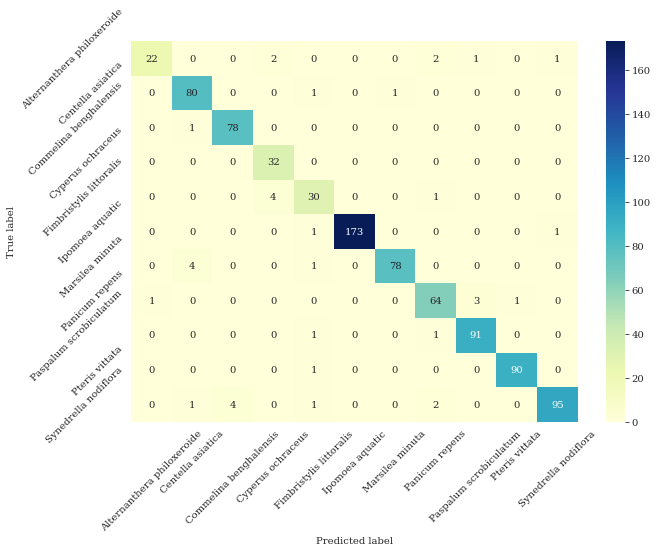

In [ ]:
conf_matrix(Y_test,predictions)

ROC AUC score: 0.9684321019844293


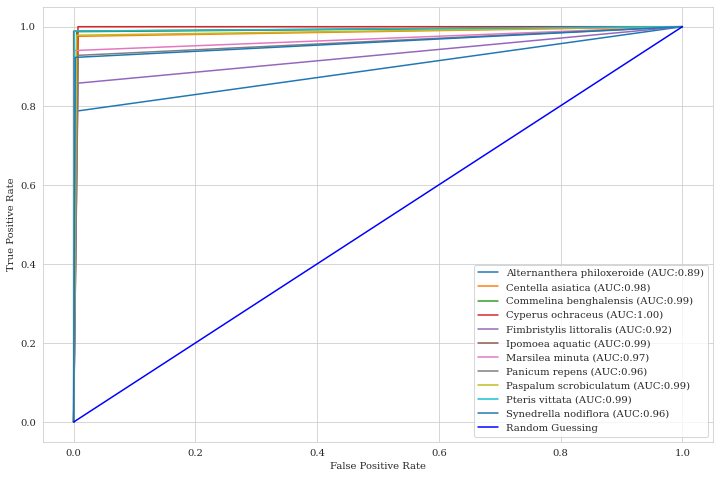

In [ ]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
print('ROC AUC score:', multiclass_roc_auc_score(Y_test,predictions))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


# Inception V3

In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
def incV3_model(input_shape):
    IncV3 = InceptionV3(include_top = False, weights = "imagenet",input_shape = (input_shape))
    model = Sequential()
    model.add(IncV3)
    
    for layer in model.layers:
        layer.trainable = False


    model.add(Flatten())

    model.add(Dense(units = 2048, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units = 11, activation = "softmax"))
    
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=128):
    model = None
    input_shape = 150,150,3
    model = incV3_model(input_shape)
    results = model.fit_generator(datagen.flow(t_x, t_y, batch_size=BATCH_SIZE),
                              epochs = EPOCHS, validation_data = (val_x,val_y),
                              callbacks= callbacks,
                              verbose = 1, steps_per_epoch= t_x.shape[0] // 128)
    
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [ ]:
checkpoint_path = 'F:\\Ml files\\Weed detection\\flower recognition\\model\\K-fold-11_inceptionV3.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False),
    acc_callback
]

In [ ]:
n_folds=5
epochs = 100
batch_size = 128

INCV3_model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    INCV3_model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              37750784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                22539     
Total params: 59,576,107
Trainable params: 37,773,323
Non-trainable params: 21,802,784
_________________________________________________________________


C:\Users\Ovi\anaconda3\envs\tensrgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
24/24 [==============================] - 59s 2s/step - loss: 21.1998 - accuracy: 0.2964 - val_loss: 1.4215 - val_accuracy: 0.6523

Epoch 00001: val_loss improved from inf to 1.42147, saving model to F:\Ml files\Weed detection\flower recognition\model\K-fold-11_inceptionV3.h5
Epoch 2/100
24/24 [==============================] - 14s 579ms/step - loss: 1.4268 - accuracy: 0.6600 - val_loss: 0.6368 - val_accuracy: 0.8017

Epoch 00002: val_loss improved from 1.42147 to 0.63676, saving model to F:\Ml files\Weed detection\flower recognition\model\K-fold-11_inceptionV3.h5
Epoch 3/100
24/24 [==============================] - 14s 586ms/step - loss: 0.7957 - accuracy: 0.7515 - val_loss: 0.5090 - val_accuracy: 0.8477

Epoch 00003: val_loss improved from 0.63676 to 0.50899, saving model to F:\Ml files\Weed detection\flower recognition\model\K-fold-11_inceptionV3.h5
Epoch 4/100
24/24 [==============================] - 14s 595ms/step - loss: 0.6312 - accuracy: 0.7894 - val_loss: 0.4418 - v

Epoch 1/100
24/24 [==============================] - 21s 634ms/step - loss: 24.7250 - accuracy: 0.2195 - val_loss: 1.5502 - val_accuracy: 0.6466

Epoch 00001: val_loss did not improve from 0.19479
Epoch 2/100
24/24 [==============================] - 15s 619ms/step - loss: 1.4763 - accuracy: 0.6317 - val_loss: 0.7942 - val_accuracy: 0.7184

Epoch 00002: val_loss did not improve from 0.19479
Epoch 3/100
24/24 [==============================] - 14s 585ms/step - loss: 0.8986 - accuracy: 0.7108 - val_loss: 0.5903 - val_accuracy: 0.8103

Epoch 00003: val_loss did not improve from 0.19479
Epoch 4/100
24/24 [==============================] - 14s 589ms/step - loss: 0.7221 - accuracy: 0.7668 - val_loss: 0.5050 - val_accuracy: 0.8448

Epoch 00004: val_loss did not improve from 0.19479
Epoch 5/100
24/24 [==============================] - 14s 595ms/step - loss: 0.6612 - accuracy: 0.7839 - val_loss: 0.4797 - val_accuracy: 0.8563

Epoch 00005: val_loss did not improve from 0.19479
Epoch 6/100
24/24 [

24/24 [==============================] - 15s 610ms/step - loss: 0.2143 - accuracy: 0.9297 - val_loss: 0.1733 - val_accuracy: 0.9425

Epoch 00041: val_loss did not improve from 0.16054
Epoch 42/100
24/24 [==============================] - 14s 597ms/step - loss: 0.2424 - accuracy: 0.9222 - val_loss: 0.1723 - val_accuracy: 0.9454

Epoch 00042: val_loss did not improve from 0.16054
Epoch 43/100
24/24 [==============================] - 14s 600ms/step - loss: 0.2583 - accuracy: 0.9098 - val_loss: 0.1719 - val_accuracy: 0.9454

Epoch 00043: val_loss did not improve from 0.16054
Epoch 44/100
24/24 [==============================] - 14s 597ms/step - loss: 0.2209 - accuracy: 0.9260 - val_loss: 0.1718 - val_accuracy: 0.9425

Epoch 00044: val_loss did not improve from 0.16054
Epoch 45/100
24/24 [==============================] - 14s 584ms/step - loss: 0.2404 - accuracy: 0.9247 - val_loss: 0.1726 - val_accuracy: 0.9425

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06


Epoch 00030: val_loss did not improve from 0.16054
Epoch 31/100
24/24 [==============================] - 15s 602ms/step - loss: 0.3000 - accuracy: 0.8973 - val_loss: 0.2294 - val_accuracy: 0.9339

Epoch 00031: val_loss did not improve from 0.16054
Epoch 32/100
24/24 [==============================] - 15s 605ms/step - loss: 0.3168 - accuracy: 0.8949 - val_loss: 0.2378 - val_accuracy: 0.9339

Epoch 00032: val_loss did not improve from 0.16054
Epoch 33/100
24/24 [==============================] - 14s 585ms/step - loss: 0.2958 - accuracy: 0.9010 - val_loss: 0.2324 - val_accuracy: 0.9224

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00033: val_loss did not improve from 0.16054
Epoch 34/100
24/24 [==============================] - 14s 590ms/step - loss: 0.2719 - accuracy: 0.9091 - val_loss: 0.2269 - val_accuracy: 0.9282

Epoch 00034: val_loss did not improve from 0.16054
Epoch 35/100
24/24 [==============================] - 15s 611ms/step - loss: 0

24/24 [==============================] - 14s 580ms/step - loss: 0.3922 - accuracy: 0.8719 - val_loss: 0.2868 - val_accuracy: 0.9109

Epoch 00013: val_loss did not improve from 0.16054
Epoch 14/100
24/24 [==============================] - 14s 589ms/step - loss: 0.4042 - accuracy: 0.8665 - val_loss: 0.2719 - val_accuracy: 0.9167

Epoch 00014: val_loss did not improve from 0.16054
Epoch 15/100
24/24 [==============================] - 14s 585ms/step - loss: 0.3516 - accuracy: 0.8849 - val_loss: 0.2972 - val_accuracy: 0.9138

Epoch 00015: val_loss did not improve from 0.16054
Epoch 16/100
24/24 [==============================] - 14s 590ms/step - loss: 0.3701 - accuracy: 0.8761 - val_loss: 0.2677 - val_accuracy: 0.9080

Epoch 00016: val_loss did not improve from 0.16054
Epoch 17/100
24/24 [==============================] - 14s 591ms/step - loss: 0.3551 - accuracy: 0.8856 - val_loss: 0.2595 - val_accuracy: 0.9080

Epoch 00017: val_loss did not improve from 0.16054
Epoch 18/100
24/24 [========

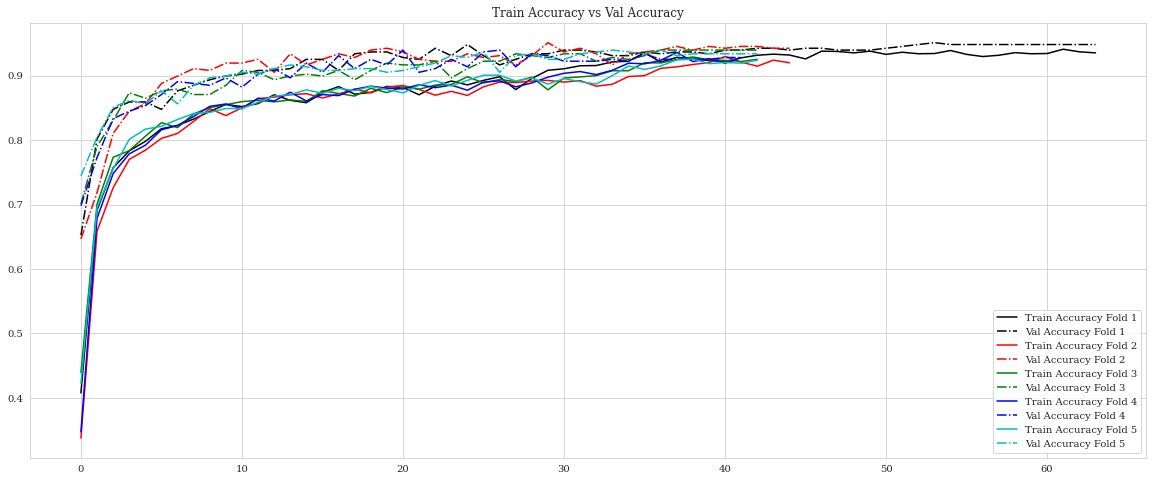

In [ ]:
plt.figure(figsize=(20, 8))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(INCV3_model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(INCV3_model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(INCV3_model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(INCV3_model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(INCV3_model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(INCV3_model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(INCV3_model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(INCV3_model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(INCV3_model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='c', )
plt.plot(INCV3_model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='c', linestyle = "dashdot")
plt.legend()
plt.show()

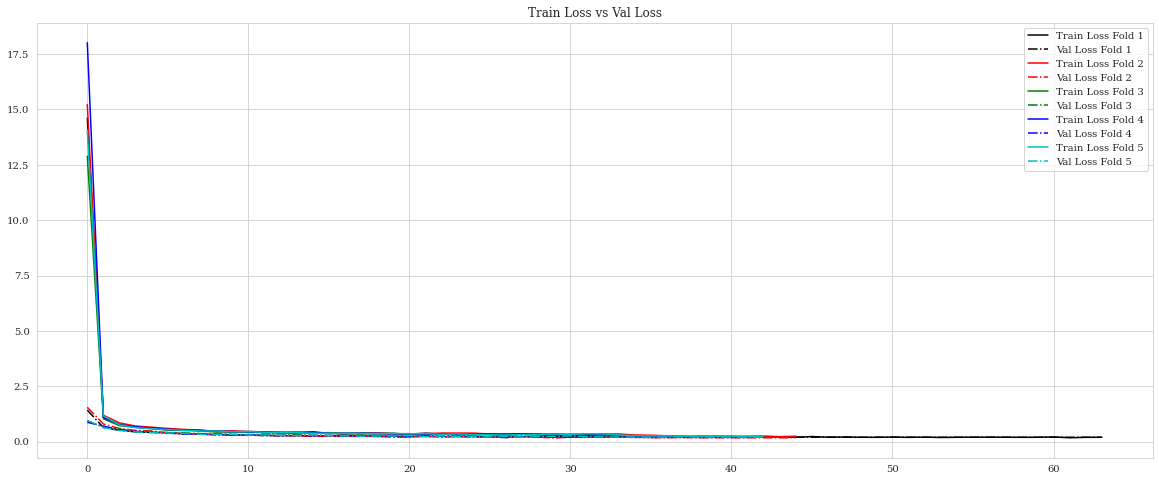

In [ ]:
# sns.set(font_scale=2)
# sns.set_style('whitegrid')
plt.figure(figsize=(20, 8))
plt.title('Train Loss vs Val Loss')
plt.plot(INCV3_model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(INCV3_model_history[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(INCV3_model_history[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(INCV3_model_history[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
plt.plot(INCV3_model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(INCV3_model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.plot(INCV3_model_history[3].history['loss'], label='Train Loss Fold 4', color='blue', )
plt.plot(INCV3_model_history[3].history['val_loss'], label='Val Loss Fold 4', color='blue', linestyle = "dashdot")
plt.plot(INCV3_model_history[4].history['loss'], label='Train Loss Fold 5', color='c', )
plt.plot(INCV3_model_history[4].history['val_loss'], label='Val Loss Fold 5', color='c', linestyle = "dashdot")
plt.legend()
plt.show()

In [ ]:
#Load the model that was saved by ModelCheckpoint
nFoldIncV3Model = load_model('F:\\Ml files\\Weed detection\\flower recognition\\model\\K-fold-11_inceptionV3.h5')
preds = nFoldIncV3Model.predict(x_test)
predictions=np.argmax(preds,axis=1)

In [ ]:
from sklearn.metrics import classification_report
Y_test =np.argmax(y_test,axis=1)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.75      0.84        28
           1       0.94      0.95      0.95        82
           2       0.96      0.97      0.97        79
           3       0.88      0.91      0.89        32
           4       0.97      0.94      0.96        35
           5       0.97      0.98      0.97       175
           6       0.90      0.87      0.88        83
           7       0.79      0.93      0.85        69
           8       0.95      0.97      0.96        93
           9       1.00      0.93      0.97        91
          10       0.88      0.85      0.87       103

    accuracy                           0.93       870
   macro avg       0.93      0.91      0.92       870
weighted avg       0.93      0.93      0.93       870



(None,
                             precision  recall  f1-score
 Alternanthera philoxeroide      95.45   75.00     84.00
 Centella asiatica               93.98   95.12     94.55
 Commelina benghalensis          96.25   97.47     96.86
 Cyperus ochraceus               87.88   90.62     89.23
 Fimbristylis littoralis         97.06   94.29     95.65
 Ipomoea aquatic                 96.61   97.71     97.16
 Marsilea minuta                 90.00   86.75     88.34
 Panicum repens                  79.01   92.75     85.33
 Paspalum scrobiculatum          94.74   96.77     95.74
 Pteris vittata                 100.00   93.41     96.59
 Synedrella nodiflora            88.00   85.44     86.70
 accuracy                        92.87   92.87     92.87
 macro avg                       92.63   91.39     91.83
 weighted avg                    93.10   92.87     92.88)

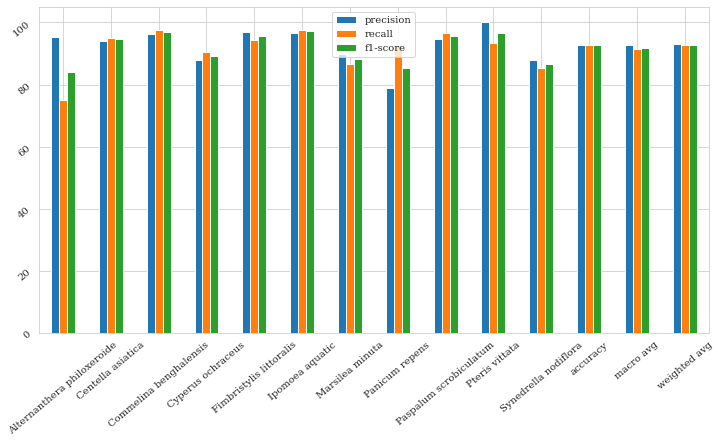

In [ ]:
report_generate(Y_test, predictions)

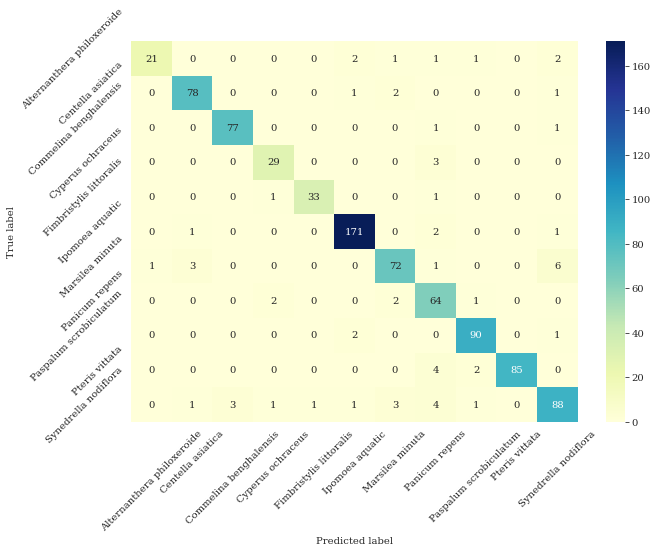

In [ ]:
conf_matrix(Y_test,predictions)

ROC AUC score: 0.9533607943152554


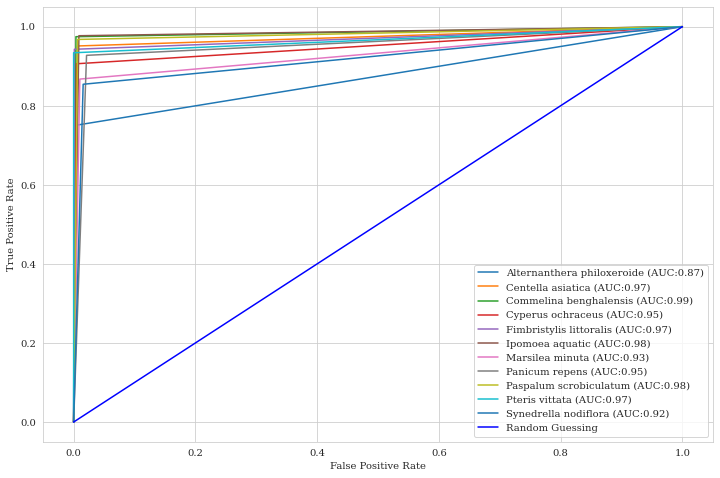

In [ ]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
print('ROC AUC score:', multiclass_roc_auc_score(Y_test,predictions))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


# DenseNet

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121
import tensorflow

In [ ]:
def DenseNet_model(input_shape):
    base_model=DenseNet121(weights='imagenet',include_top=False,input_shape = (input_shape))
    model = tensorflow.keras.Sequential([
        base_model,
        tensorflow.keras.layers.Conv2D(128, 3, activation='relu'),
        tensorflow.keras.layers.Dropout(0.2),
        tensorflow.keras.layers.GlobalAveragePooling2D(),
        tensorflow.keras.layers.Dense(11, activation='softmax')
    ])
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=128):
    model = None
    input_shape = 150,150,3
    model = DenseNet_model(input_shape)
    results = model.fit_generator(datagen.flow(t_x, t_y, batch_size=BATCH_SIZE),
                              epochs = EPOCHS, validation_data = (val_x,val_y),
                              callbacks= callbacks,
                              verbose = 1, steps_per_epoch= t_x.shape[0] // 128)
    
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [ ]:
checkpoint_path = 'F:\\Ml files\\Weed detection\\flower recognition\\model\\K-fold-11_DenseNet.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False),
    acc_callback
]

In [ ]:
n_folds=5
epochs = 20
batch_size = 128

DenseNet_model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    DenseNet_model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 128)         1179776   
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 128)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 11)                1419      
Total params: 8,218,699
Trainable params: 8,135,051
Non-trainable params: 83,648
_________________________________________________________________


C:\Users\Ovi\anaconda3\envs\tensrgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
24/24 [==============================] - 165s 4s/step - loss: 2.8713 - accuracy: 0.4215 - val_loss: 12.0701 - val_accuracy: 0.2241

Epoch 00001: val_loss improved from inf to 12.07011, saving model to F:\Ml files\Weed detection\flower recognition\model\K-fold-11_DenseNet.h5
Epoch 2/20
24/24 [==============================] - 16s 661ms/step - loss: 0.5066 - accuracy: 0.8358 - val_loss: 6.1067 - val_accuracy: 0.3736

Epoch 00002: val_loss improved from 12.07011 to 6.10669, saving model to F:\Ml files\Weed detection\flower recognition\model\K-fold-11_DenseNet.h5
Epoch 3/20
24/24 [==============================] - 16s 660ms/step - loss: 0.2662 - accuracy: 0.9233 - val_loss: 8.3159 - val_accuracy: 0.4282

Epoch 00003: val_loss did not improve from 6.10669
Epoch 4/20
24/24 [==============================] - 16s 666ms/step - loss: 0.2053 - accuracy: 0.9423 - val_loss: 5.3184 - val_accuracy: 0.4828

Epoch 00004: val_loss improved from 6.10669 to 5.31841, saving model to F:\Ml files\

24/24 [==============================] - 16s 658ms/step - loss: 0.0917 - accuracy: 0.9749 - val_loss: 2.9366 - val_accuracy: 0.7155

Epoch 00011: val_loss did not improve from 0.64205
Epoch 12/20
24/24 [==============================] - 16s 661ms/step - loss: 0.0738 - accuracy: 0.9777 - val_loss: 5.1419 - val_accuracy: 0.5287

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00012: val_loss did not improve from 0.64205
Epoch 13/20
24/24 [==============================] - 16s 661ms/step - loss: 0.0847 - accuracy: 0.9780 - val_loss: 0.9903 - val_accuracy: 0.8333

Epoch 00013: val_loss did not improve from 0.64205
Epoch 14/20
24/24 [==============================] - 16s 661ms/step - loss: 0.0308 - accuracy: 0.9929 - val_loss: 0.3052 - val_accuracy: 0.9310

Epoch 00014: val_loss improved from 0.64205 to 0.30520, saving model to F:\Ml files\Weed detection\flower recognition\model\K-fold-11_DenseNet.h5
Epoch 15/20
24/24 [==============================] 

Epoch 1/20
24/24 [==============================] - 32s 759ms/step - loss: 2.4352 - accuracy: 0.4911 - val_loss: 9.7115 - val_accuracy: 0.2701

Epoch 00001: val_loss did not improve from 0.08083
Epoch 2/20
24/24 [==============================] - 16s 664ms/step - loss: 0.3779 - accuracy: 0.8788 - val_loss: 6.7790 - val_accuracy: 0.4080

Epoch 00002: val_loss did not improve from 0.08083
Epoch 3/20
24/24 [==============================] - 16s 666ms/step - loss: 0.2576 - accuracy: 0.9233 - val_loss: 1.9598 - val_accuracy: 0.5086

Epoch 00003: val_loss did not improve from 0.08083
Epoch 4/20
24/24 [==============================] - 16s 665ms/step - loss: 0.1571 - accuracy: 0.9505 - val_loss: 2.3337 - val_accuracy: 0.6149

Epoch 00004: val_loss did not improve from 0.08083
Epoch 5/20
24/24 [==============================] - 16s 667ms/step - loss: 0.1320 - accuracy: 0.9561 - val_loss: 2.0073 - val_accuracy: 0.6580

Epoch 00005: val_loss did not improve from 0.08083
Epoch 6/20
24/24 [=======

24/24 [==============================] - 16s 666ms/step - loss: 0.0493 - accuracy: 0.9856 - val_loss: 0.6073 - val_accuracy: 0.8707

Epoch 00014: val_loss did not improve from 0.04993
Epoch 15/20
24/24 [==============================] - 16s 667ms/step - loss: 0.0634 - accuracy: 0.9807 - val_loss: 0.8156 - val_accuracy: 0.8391

Epoch 00015: val_loss did not improve from 0.04993
Epoch 16/20
24/24 [==============================] - 16s 664ms/step - loss: 0.0711 - accuracy: 0.9829 - val_loss: 4.9118 - val_accuracy: 0.5144

Epoch 00016: val_loss did not improve from 0.04993
Epoch 17/20
24/24 [==============================] - 16s 666ms/step - loss: 0.0595 - accuracy: 0.9819 - val_loss: 1.7661 - val_accuracy: 0.6609

Epoch 00017: val_loss did not improve from 0.04993
Epoch 18/20
24/24 [==============================] - 16s 661ms/step - loss: 0.0740 - accuracy: 0.9806 - val_loss: 0.7502 - val_accuracy: 0.8851

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

E

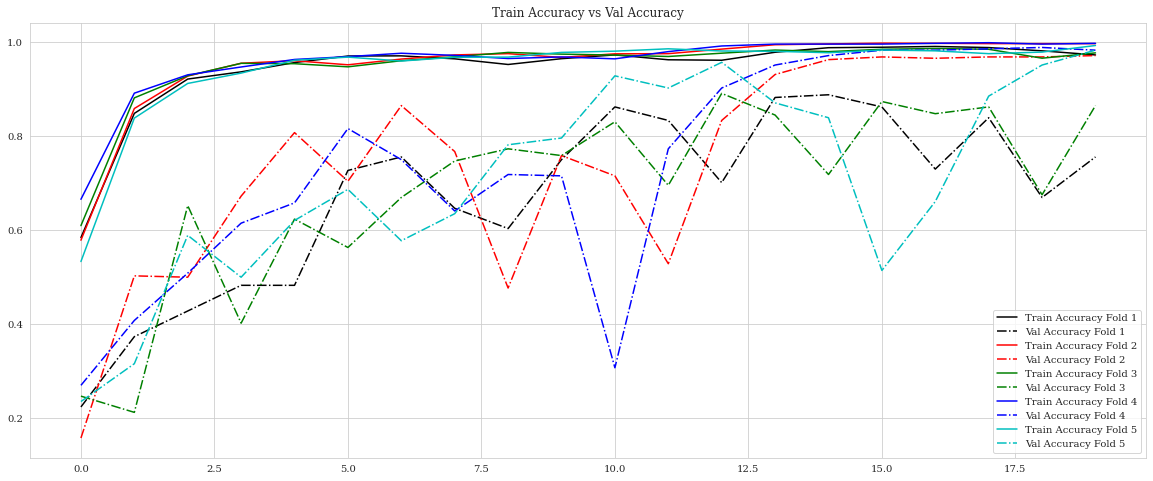

In [ ]:
plt.figure(figsize=(20, 8))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(DenseNet_model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(DenseNet_model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(DenseNet_model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(DenseNet_model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(DenseNet_model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(DenseNet_model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(DenseNet_model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(DenseNet_model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(DenseNet_model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='c', )
plt.plot(DenseNet_model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='c', linestyle = "dashdot")
plt.legend()
plt.show()

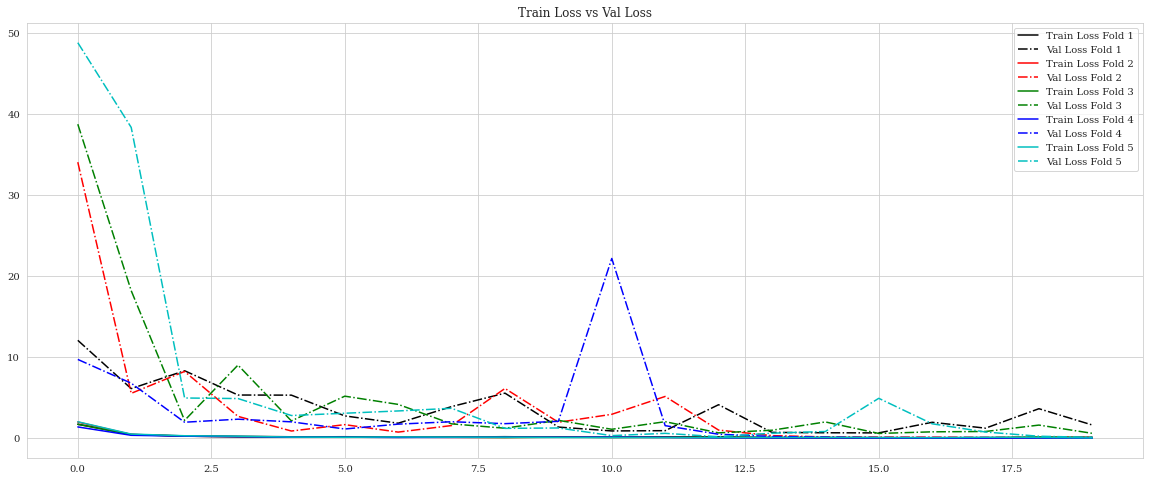

In [ ]:
# sns.set(font_scale=2)
# sns.set_style('whitegrid')
plt.figure(figsize=(20, 8))
plt.title('Train Loss vs Val Loss')
plt.plot(DenseNet_model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(DenseNet_model_history[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(DenseNet_model_history[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(DenseNet_model_history[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
plt.plot(DenseNet_model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(DenseNet_model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.plot(DenseNet_model_history[3].history['loss'], label='Train Loss Fold 4', color='blue', )
plt.plot(DenseNet_model_history[3].history['val_loss'], label='Val Loss Fold 4', color='blue', linestyle = "dashdot")
plt.plot(DenseNet_model_history[4].history['loss'], label='Train Loss Fold 5', color='c', )
plt.plot(DenseNet_model_history[4].history['val_loss'], label='Val Loss Fold 5', color='c', linestyle = "dashdot")
plt.legend()
plt.show()

In [ ]:
#Load the model that was saved by ModelCheckpoint
nFoldDenseModel = load_model('F:\\Ml files\\Weed detection\\flower recognition\\model\\K-fold-11_DenseNet.h5')
preds = nFoldDenseModel.predict(x_test)
predictions=np.argmax(preds,axis=1)

In [ ]:
from sklearn.metrics import classification_report
Y_test =np.argmax(y_test,axis=1)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        28
           1       0.99      0.99      0.99        82
           2       0.98      1.00      0.99        79
           3       1.00      0.84      0.92        32
           4       0.97      1.00      0.99        35
           5       1.00      0.99      1.00       175
           6       0.99      0.99      0.99        83
           7       0.97      0.97      0.97        69
           8       0.99      1.00      0.99        93
           9       1.00      1.00      1.00        91
          10       0.94      1.00      0.97       103

    accuracy                           0.98       870
   macro avg       0.98      0.97      0.97       870
weighted avg       0.98      0.98      0.98       870



(None,
                             precision  recall  f1-score
 Alternanthera philoxeroide     100.00   85.71     92.31
 Centella asiatica               98.78   98.78     98.78
 Commelina benghalensis          97.53  100.00     98.75
 Cyperus ochraceus              100.00   84.38     91.53
 Fimbristylis littoralis         97.22  100.00     98.59
 Ipomoea aquatic                100.00   99.43     99.71
 Marsilea minuta                 98.80   98.80     98.80
 Panicum repens                  97.10   97.10     97.10
 Paspalum scrobiculatum          98.94  100.00     99.47
 Pteris vittata                 100.00  100.00    100.00
 Synedrella nodiflora            94.50  100.00     97.17
 accuracy                        98.39   98.39     98.39
 macro avg                       98.44   96.74     97.47
 weighted avg                    98.44   98.39     98.36)

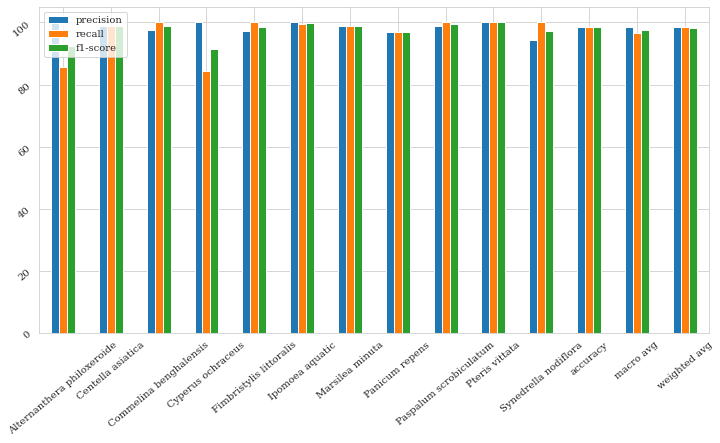

In [ ]:
report_generate(Y_test, predictions)

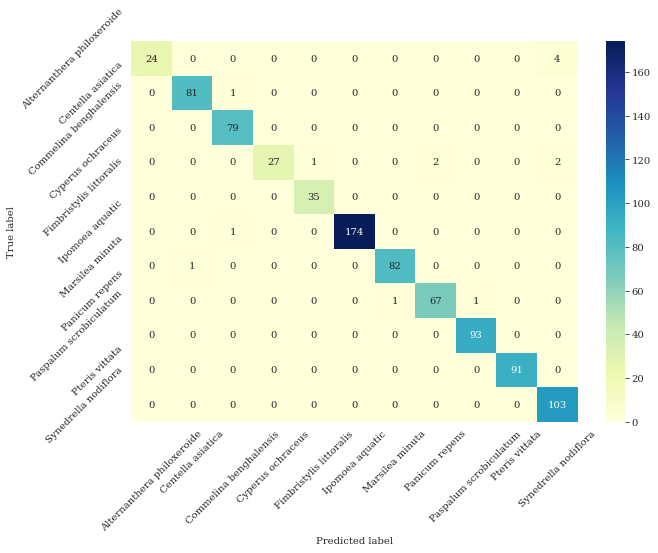

In [ ]:
conf_matrix(Y_test,predictions)

ROC AUC score: 0.9829126113692044


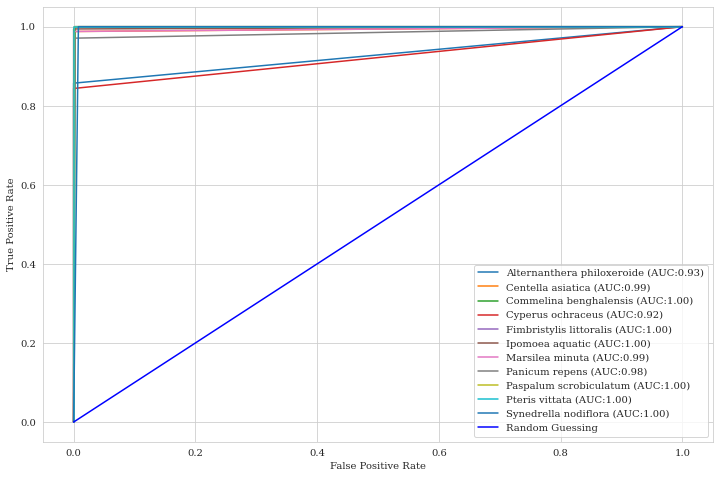

In [ ]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)
print('ROC AUC score:', multiclass_roc_auc_score(Y_test,predictions))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()
